In [1]:
import pandas as pd

import pickle

import numpy as np

import re
import string

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

In [2]:
with open('../data/interim/02_cleaned.pkl', 'rb') as picklefile:
    df_listings = pickle.load(picklefile)

In [3]:
property_types = df_listings['property_type'].unique()
quirky = [x for x in property_types if x not in ['Apartment', 'House', 'Condominium', 'Townhouse']]

In [4]:
for property_type in quirky:
    df_listings['property_type'].replace(to_replace=property_type, value='Quirky', inplace=True)

In [5]:
loc = ['neighborhood', 'city', 'state']

In [6]:
df_grouped = df_listings.groupby(loc)

In [7]:
df_rec = df_grouped.count()['id'].reset_index()
df_rec.rename(columns={'id': 'total_listings'}, inplace=True)

In [8]:
#categorical features to be converted into distributions by neighborhood
#i.e. what percentage of listings have a superhost vs not a superhost for a given neighborhood?
distributions = ['host_is_superhost', 'host_response_time', 'cancellation_policy', \
                 'room_type', 'property_type', 'bed_type']

In [9]:
df_totals = df_rec[loc]
for variable in distributions:
    print variable

    df = df_listings.groupby(['neighborhood', 'city', 'state', variable]).size().unstack().reset_index().fillna(0)

    cols = ['neighborhood', 'city', 'state']
    for value in df_listings[variable].unique():
        col = variable + '_' + value
        cols.append(col)
    
    #last_col = cols.pop()
    #df.drop(last_col, axis=1, inplace=True)
    
    df.columns = cols
    df_totals = df_totals.merge(df)

host_is_superhost
host_response_time
cancellation_policy
room_type
property_type
bed_type


In [10]:
df_totals.iloc[:,3:] = df_totals.iloc[:,3:].div(df_rec['total_listings'], axis=0)

In [11]:
df_rec = df_rec.merge(df_totals)

In [12]:
#numerical features to be converted into median
medians = ['bathrooms', 'number_of_reviews', 'reviews_per_month', 'review_scores_accuracy', \
          'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', \
          'review_scores_location', 'review_scores_rating', 'review_scores_value', 'price']

In [13]:
#median price and ratings
df_medians = df_grouped.median()[medians].reset_index()

In [14]:
df_rec = df_rec.merge(df_medians)

In [15]:
df_rec.sample(n=5)

,neighborhood,city,state,total_listings,host_is_superhost_f,host_is_superhost_t,host_response_time_no response,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,...,number_of_reviews,reviews_per_month,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,price
819,Linda Vista,sandiego,CA,52,0.730769,0.269231,0.000000,0.153846,0.076923,0.326923,...,6.0,0.925,10.0,10.0,10.0,10.0,9.0,96.0,10.0,79.0
868,Maple Leaf,seattle,WA,35,0.714286,0.285714,0.000000,0.028571,0.285714,0.257143,...,17.0,1.260,10.0,10.0,10.0,10.0,9.0,96.0,10.0,80.0
1482,Sursum Corda Cooperative,washingtondc,DC,6,1.000000,0.000000,0.000000,0.000000,0.333333,0.333333,...,10.5,2.485,10.0,10.0,10.0,10.0,9.5,95.5,9.5,127.0
62,Barrio Logan,sandiego,CA,8,1.000000,0.000000,0.000000,0.125000,0.000000,0.250000,...,18.0,1.490,10.0,10.0,10.0,10.0,8.5,94.5,9.0,150.0
417,East Village,sandiego,CA,151,0.860927,0.139073,0.006623,0.079470,0.086093,0.298013,...,6.0,1.400,10.0,10.0,10.0,10.0,10.0,96.0,10.0,120.0


In [16]:
df_rec.describe()

,total_listings,host_is_superhost_f,host_is_superhost_t,host_response_time_no response,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,host_response_time_a few days or more,cancellation_policy_moderate,cancellation_policy_strict,...,number_of_reviews,reviews_per_month,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,price
count,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,...,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000,1727.000000
mean,52.174291,0.796176,0.203824,0.012988,0.073491,0.131084,0.253100,0.529338,0.285025,0.338632,...,13.306891,1.610402,9.839896,9.935437,9.721193,9.940938,9.429068,95.667053,9.649682,107.935148
std,174.933079,0.239488,0.239488,0.057344,0.127047,0.177958,0.231935,0.289229,0.251680,0.258828,...,14.361666,1.130291,0.445124,0.304991,0.545446,0.328252,0.759284,4.215450,0.542812,63.592786
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.045000,4.000000,6.000000,6.000000,4.000000,4.000000,40.000000,5.500000,1.000000
25%,3.000000,0.714286,0.000000,0.000000,0.000000,0.000000,0.043478,0.353300,0.125000,0.185431,...,6.000000,0.950000,10.000000,10.000000,9.500000,10.000000,9.000000,94.500000,9.000000,70.000000
50%,11.000000,0.857143,0.142857,0.000000,0.023810,0.095679,0.240385,0.500000,0.246445,0.313725,...,10.000000,1.315000,10.000000,10.000000,10.000000,10.000000,10.000000,96.500000,10.000000,95.000000
75%,40.000000,1.000000,0.285714,0.000000,0.105263,0.187500,0.333333,0.704793,0.375000,0.449127,...,15.500000,2.000000,10.000000,10.000000,10.000000,10.000000,10.000000,98.000000,10.000000,125.000000
max,3428.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,215.000000,10.700000,10.000000,10.000000,10.000000,10.000000,10.000000,100.000000,10.000000,905.000000


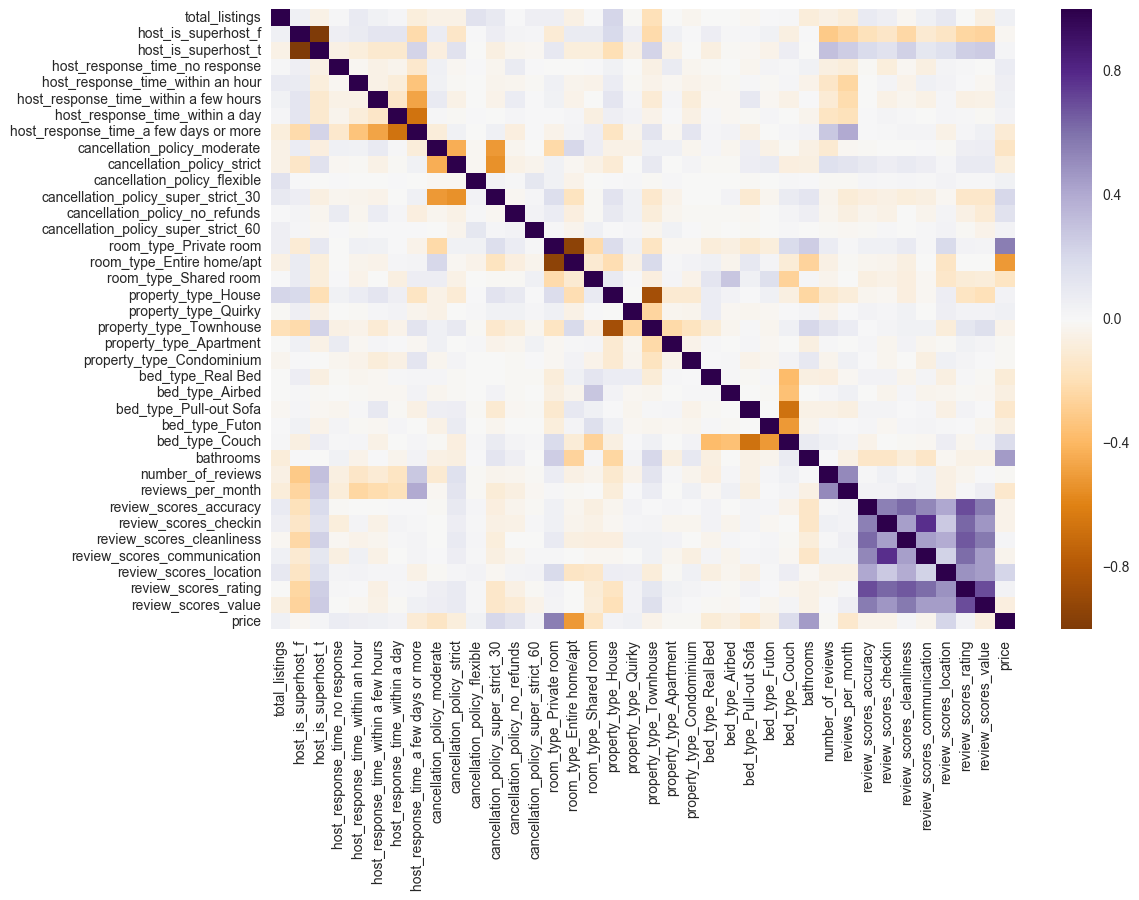

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(df_rec.corr(), ax=ax, cmap="PuOr");

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import euclidean_distances

In [28]:
df_rec.iloc[:,4:].head()

,host_is_superhost_f,host_is_superhost_t,host_response_time_no response,host_response_time_within an hour,host_response_time_within a few hours,host_response_time_within a day,host_response_time_a few days or more,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_flexible,...,number_of_reviews,reviews_per_month,review_scores_accuracy,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,price
0,1.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000,0.0,...,6.0,0.97,10.0,10.0,9.5,10.0,10.0,100.0,9.5,142.5
1,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,...,15.0,0.51,9.0,8.0,8.0,8.0,10.0,83.0,9.0,180.0
2,0.600000,0.400000,0.0,0.000000,0.000000,0.000000,1.000000,0.200000,0.000000,0.0,...,14.0,2.08,10.0,10.0,10.0,10.0,10.0,98.0,10.0,375.0
3,1.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,31.0,3.06,10.0,10.0,10.0,10.0,8.0,92.0,10.0,65.0
4,0.888889,0.111111,0.0,0.111111,0.222222,0.444444,0.222222,0.444444,0.111111,0.0,...,12.0,1.27,10.0,10.0,10.0,10.0,10.0,97.0,10.0,59.0


In [29]:
dists = cosine_similarity(df_rec.iloc[:,4:])

In [30]:
neighborhoods = df_rec['neighborhood'].apply(lambda u: u.encode('utf-8')).tolist()
cities = df_rec['city'].tolist()
states = df_rec['state'].apply(lambda u: u.encode('utf-8')).tolist()

zipped = zip(neighborhoods, cities, states)

In [31]:
' '.join(zipped[0])

'Abbington Park Condos nashville TN'

In [32]:
neighborhoods = df_rec['neighborhood']
dists = pd.DataFrame(dists, columns=zipped)

In [33]:
dists.index = dists.columns

In [34]:
dists.head()

,"(Abbington Park Condos, nashville, TN)","(Abbot Martin Estates, nashville, TN)","(Acklen Avenue Alliance, nashville, TN)","(Acorn, oakland, CA)","(Adams Hill, losangeles, CA)","(Adams Morgan, washingtondc, DC)","(Adams North, sandiego, CA)","(Adams Point, oakland, CA)","(Adams-Normandie, losangeles, CA)","(Admiral, seattle, WA)",...,"(Wooten, austin, TX)","(Wrightwood Neighbors, chicago, IL)","(Wrigley, losangeles, CA)","(Wrigleyville, chicago, IL)","(Yerba Buena, sanfrancisco, CA)","(Yerba Buena Island, sanfrancisco, CA)","(Yesler Terrace, seattle, WA)","(Your Neighborhood Group, nashville, TN)","(Zaferia, losangeles, CA)","(Zilker, austin, TX)"
"(Abbington Park Condos, nashville, TN)",1.000000,0.982779,0.935173,0.916362,0.914084,0.996486,0.983367,0.978041,0.947649,0.985323,...,0.985467,0.999684,0.960109,0.998950,0.998878,0.838652,0.996640,0.928171,0.985894,0.994716
"(Abbot Martin Estates, nashville, TN)",0.982779,1.000000,0.982867,0.851366,0.829793,0.965765,0.940283,0.925390,0.877520,0.943819,...,0.938583,0.986442,0.894143,0.980948,0.973809,0.774939,0.993627,0.980382,0.939432,0.995529
"(Acklen Avenue Alliance, nashville, TN)",0.935173,0.982867,1.000000,0.742333,0.713982,0.903624,0.862123,0.841849,0.775658,0.867342,...,0.861799,0.942611,0.799342,0.929397,0.918449,0.655900,0.960474,0.999067,0.863210,0.966251
"(Acorn, oakland, CA)",0.916362,0.851366,0.742333,1.000000,0.984710,0.943959,0.972469,0.969909,0.984688,0.970092,...,0.960527,0.909357,0.974713,0.929638,0.930436,0.980779,0.885544,0.739995,0.960228,0.876366
"(Adams Hill, losangeles, CA)",0.914084,0.829793,0.713982,0.984710,1.000000,0.944414,0.969808,0.978325,0.995561,0.967440,...,0.969073,0.905341,0.990027,0.921900,0.931098,0.942105,0.878658,0.704274,0.968354,0.868201


In [36]:
dists[('Russian Hill', 'sanfrancisco', 'CA')].sort_values(ascending=False)[:10]

(Russian Hill, sanfrancisco, CA)        1.000000
(Cow Hollow, sanfrancisco, CA)          0.999980
(The Loop, chicago, IL)                 0.999975
(Pacific Heights, sanfrancisco, CA)     0.999951
(Lathrop Homes, chicago, IL)            0.999943
(Point Dume, losangeles, CA)            0.999942
(Greenwich Village, newyorkcity, NY)    0.999932
(Pennington Bend, nashville, TN)        0.999928
(Capitol Hill Area, nashville, TN)      0.999924
(West Village, newyorkcity, NY)         0.999916
Name: (Russian Hill, sanfrancisco, CA), dtype: float64